<a href="https://colab.research.google.com/github/4eonBlast/Bigdata_team_project/blob/main/vaccination_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies

In [2]:
import numpy as np
import pandas as pd
from os import path
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 전처리

In [5]:
DATA_DIRECTORY = '/content/drive/MyDrive/Bigdata/dataset'

# 데이터 불러오기
vaccination_df = pd.read_csv(path.join(DATA_DIRECTORY, 'country_vaccinations.csv'))
gdp_growth_df = pd.read_csv(path.join(DATA_DIRECTORY, 'GDP_annual_growth_NEW.csv'))
demographics_df = pd.read_csv(path.join(DATA_DIRECTORY, 'world_demographics.csv'))
coronavirus_data_df = pd.read_csv(path.join(DATA_DIRECTORY, 'worldometer_coronavirus_daily_data.csv'))
country_info = pd.read_csv(path.join(DATA_DIRECTORY,'countries_of_world.csv'))
population_info = pd.read_csv(path.join(DATA_DIRECTORY,'population_by_country_2020.csv'))

In [6]:
# 국가별 최근 접종률
vaccine_country_max = vaccination_df.groupby('country').max('people_fully_vaccinated_per_hundred')
vaccine_country_max = vaccine_country_max['people_fully_vaccinated_per_hundred']

# 예측 대상 국가들
# target_countries = vaccine_country_max[(vaccine_country_max >= 50.) & (vaccine_country_max < 70.)]
target_countries = vaccine_country_max[(vaccine_country_max >= 70.) & (vaccine_country_max < 100.)]
target_countries.sort_values(ascending=False).head(20)

country
Singapore               91.91
Portugal                88.56
United Arab Emirates    88.40
Cayman Islands          84.49
Chile                   84.44
Malta                   83.89
Cuba                    82.06
Iceland                 81.96
South Korea             80.71
Spain                   80.55
Brunei                  79.66
Cambodia                79.16
Seychelles              78.81
Faeroe Islands          77.76
Malaysia                77.62
Japan                   77.57
Denmark                 76.91
China                   76.89
Canada                  76.50
Uruguay                 76.35
Name: people_fully_vaccinated_per_hundred, dtype: float64

In [ ]:
def extract_time_series(data, columns, countries):
    # 특정 국가만
    result = data[data.country.isin(countries)]
    # 필요한 column만
    columns = ['country', 'date'] + columns
    result = result[columns]
    # 날짜 변환
    # 이걸 해야 뒤에 나오는 inner join이 제대로 이루어진다
    result['date'] = pd.to_datetime(result['date'])
    return result

In [ ]:
# COUNTRIES = ['South Korea']
COUNTRIES = target_countries.keys()
print(COUNTRIES)
# 접종률 70% 넘긴 국가들
sampled_vaccination = extract_time_series(vaccination_df, ['people_fully_vaccinated_per_hundred'], COUNTRIES)
# 각 국가별로 null 확인
# sampled_vaccination.groupby('country').people_fully_vaccinated_per_hundred.agg(lambda x: x.isnull().sum()).sort_values()

# TODO 접종률 null값 보간 하기
sampled_vaccination = sampled_vaccination.fillna(method='pad')
# print(sampled_vaccination.head())
# print(sampled_vaccination.isnull().sum())
sampled_vaccination = sampled_vaccination.fillna(0)

print(sampled_vaccination.isnull().sum())
# 접종률 증가율 추가
sampled_vaccination['vaccination_diff_1'] = sampled_vaccination.people_fully_vaccinated_per_hundred.diff()
sampled_vaccination = sampled_vaccination.dropna()
sampled_vaccination = sampled_vaccination[sampled_vaccination.vaccination_diff_1 >= 0]

# sns.lineplot(data=sampled_vaccination.vaccination_diff_1)

Index(['Aruba', 'Australia', 'Belgium', 'Bermuda', 'Bhutan', 'Brunei',
       'Cambodia', 'Canada', 'Cayman Islands', 'Chile', 'China', 'Cuba',
       'Denmark', 'Faeroe Islands', 'Finland', 'France', 'Iceland', 'Ireland',
       'Isle of Man', 'Italy', 'Japan', 'Jersey', 'Kuwait', 'Malaysia',
       'Malta', 'Mauritius', 'Netherlands', 'New Zealand', 'Niue',
       'Northern Cyprus', 'Norway', 'Portugal', 'Qatar', 'Scotland',
       'Seychelles', 'Singapore', 'South Korea', 'Spain', 'Sweden', 'Tokelau',
       'United Arab Emirates', 'Uruguay', 'Wales'],
      dtype='object', name='country')
country                                0
date                                   0
people_fully_vaccinated_per_hundred    0
dtype: int64


In [ ]:
# 70% 이상 국가들의 일간 확진판정
sampled_covid_data = extract_time_series(coronavirus_data_df, ['daily_new_cases', 'daily_new_deaths'], COUNTRIES)
# sampled_covid_data.groupby('country').daily_new_cases.agg(lambda x: x.isnull().sum()).sort_values()

sampled_covid_data = sampled_covid_data.dropna()

# sns.lineplot(data=sampled_covid_data)

In [ ]:
# 날짜로 inner join
sampled_data = pd.merge(sampled_vaccination, sampled_covid_data, how='inner', on=['country', 'date'])
sampled_data.tail()
# sampled_data.info()

,country,date,people_fully_vaccinated_per_hundred,vaccination_diff_1,daily_new_cases,daily_new_deaths
10996,Uruguay,2021-11-28,76.20,0.00,167.0,4.0
10997,Uruguay,2021-11-29,76.24,0.04,156.0,1.0
10998,Uruguay,2021-11-30,76.25,0.01,191.0,1.0
10999,Uruguay,2021-12-01,76.27,0.02,271.0,0.0
11000,Uruguay,2021-12-02,76.29,0.02,309.0,1.0


In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


## 랜덤 포레스트

한달 전 데이터를 가지고 다음날 당일 접종률 예측하기

### 데이터 가공

In [ ]:
# Normalize scale
# scaler = StandardScaler()
scaler = MinMaxScaler()
columns = ['people_fully_vaccinated_per_hundred', 'vaccination_diff_1', 'daily_new_cases', 'daily_new_deaths']
sampled_scaled_data = sampled_data.copy()
sampled_scaled_data[columns] = scaler.fit_transform(sampled_data[columns])

# 안 쓰는 column 삭제
# sampled_scaled_data = sampled_scaled_data.drop(['date', 'people_fully_vaccinated_per_hundred'], axis=1)
sampled_scaled_data = sampled_scaled_data.drop(['date', 'vaccination_diff_1'], axis=1)

# sns.lineplot(data=sampled_scaled_data)

In [ ]:
WINDOW = 29
LAG = 1

# 각 국가별로 따로따로 supervised 학습 데이터 생성
sampled_ml_data = []
for country_name in sampled_scaled_data.country.unique():
    data = sampled_scaled_data[sampled_scaled_data.country == country_name]
    data = series_to_supervised(data.drop('country', axis=1), WINDOW, LAG)
    data['country'] = country_name

    sampled_ml_data.append(data)

# 그리고 합체
sampled_ml_data = pd.concat(sampled_ml_data)
# 예측하지 않을 column 삭제
sampled_ml_data = sampled_ml_data.drop(['daily_new_cases(t+%d)' % LAG, 'daily_new_deaths(t+%d)' % LAG], axis=1)
# 국가 -> 코드
country_encoder = LabelEncoder()
sampled_ml_data.country = country_encoder.fit_transform(sampled_ml_data.country)

# sampled_ml_data.info()

### 학습

In [ ]:
# 학습/테스트 dataset 분리
# LABEL_NAME = ['vaccination_diff_1(t+1)']
LABEL_NAME = ['people_fully_vaccinated_per_hundred(t+1)']
x, y = sampled_ml_data.drop(LABEL_NAME, axis=1), sampled_ml_data[LABEL_NAME]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, shuffle=False)

# x_train.info()
# y_train.info()

In [ ]:
# 학습
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=99)
# model = LGBMRegressor(n_estimators=1000, learning_rate=0.02, n_jobs=-1, random_state=99)
model.fit(x_train, y_train)

# 모델 평가
prediction_test = model.predict(x_test)
error = mean_squared_error(y_test, prediction_test, squared=False)
error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.033102637104709245

In [ ]:
# column 하나만 inverse_transform
def invTransform(scaler, data, colName):
    colNames = scaler.feature_names_in_
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [ ]:
# scaled -> 원래 값으로
# label_result = invTransform(scaler, y_test.values, 'vaccination_diff_1')
# prediction_result = invTransform(scaler, prediction_test, 'vaccination_diff_1')
label_result = invTransform(scaler, y_test.values, 'people_fully_vaccinated_per_hundred')
prediction_result = invTransform(scaler, prediction_test, 'people_fully_vaccinated_per_hundred')

result = pd.DataFrame(data={
    'label': label_result,
    'prediction': prediction_result
})
sns.lineplot(data=result)

## LSTM

한달 전 데이터 가지고 다음날 접종률 예측하기

### 데이터 가공

In [ ]:
# Normalize scale
# scaler = StandardScaler()
scaler = MinMaxScaler()
columns = ['people_fully_vaccinated_per_hundred', 'vaccination_diff_1', 'daily_new_cases', 'daily_new_deaths']
sampled_scaled_data = sampled_data.copy()
sampled_scaled_data[columns] = scaler.fit_transform(sampled_data[columns])

# 안 쓰는 column 삭제
sampled_scaled_data = sampled_scaled_data.drop(['date', 'vaccination_diff_1'], axis=1)

# sns.lineplot(data=sampled_scaled_data)
# sampled_scaled_data.info()

In [ ]:
WINDOW = 30
LAG = 1

# 각 국가별로 따로따로 supervised 학습 데이터 생성
sampled_ml_data = []
for country_name in sampled_scaled_data.country.unique():
    data = sampled_scaled_data[sampled_scaled_data.country == country_name]
    data = series_to_supervised(data.drop('country', axis=1), WINDOW - 1, LAG)
    data['country'] = country_name

    sampled_ml_data.append(data)

# 그리고 합체
sampled_ml_data = pd.concat(sampled_ml_data)
# 예측하지 않을 column 삭제
sampled_ml_data = sampled_ml_data.drop(['daily_new_cases(t+%d)' % LAG, 'daily_new_deaths(t+%d)' % LAG, 'country'], axis=1)

sampled_ml_data.info()

### 학습

In [ ]:
# 학습/테스트 dataset 분리
LABEL_NAME = ['people_fully_vaccinated_per_hundred(t+1)']
x, y = sampled_ml_data.drop(LABEL_NAME, axis=1), sampled_ml_data[LABEL_NAME]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, shuffle=False)

# x_train.info()
# y_train.info()

In [ ]:
# LSTM에 맞게 크기 조정
x_train_reshaped = x_train.values.reshape((x_train.shape[0], WINDOW, -1))
x_test_reshaped = x_test.values.reshape((x_test.shape[0], WINDOW, -1))

# 학습
model = Sequential()
model.add(LSTM(64, input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train_reshaped, y_train, epochs=100, batch_size=256, validation_data=(x_test_reshaped, y_test), verbose=2, shuffle=False)
sns.lineplot(data=history.history)

# 모델 평가
prediction_test = model.predict(x_test_reshaped)
error = mean_squared_error(y_test, prediction_test, squared=False)
error


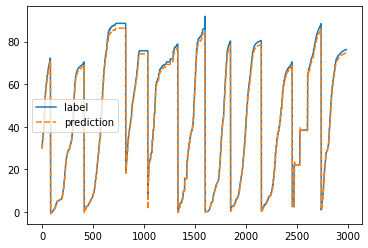

In [ ]:
# scaled -> 원래 값으로
label_result = invTransform(scaler, y_test.values, 'people_fully_vaccinated_per_hundred')
prediction_result = invTransform(scaler, prediction_test, 'people_fully_vaccinated_per_hundred')

result = pd.DataFrame(data={
    'label': label_result,
    'prediction': prediction_result
})
sns.lineplot(data=result)

## 선형 회귀

### 데이터 가공

In [ ]:
def sigmoid(data):
    return 1 / (1 + np.exp(-data))

In [ ]:
# 일단 한 국가를 대상으로
print(sampled_data)
sample_data_ml = sampled_data[sampled_data.country == 'South Korea']
# 안 쓰는 column 삭제
sample_data_ml = sample_data_ml.drop(['country', 'vaccination_diff_1', 'daily_new_cases', 'daily_new_deaths'], axis=1)

# 날짜 -> 숫자
sample_date = sample_data_ml.date.apply(lambda x: x.toordinal())
sample_date = sample_date - sample_date.min()
sample_data_ml.date = sample_date
# 그리고 normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
sample_scaled_data_ml = scaler.fit_transform(sample_data_ml)
sample_data_ml[:] = sample_scaled_data_ml

# Sigmoid 적용
sample_data_ml['vaccination_sigmoid'] = sample_data_ml.people_fully_vaccinated_per_hundred.apply(sigmoid)
# Polynomial 적용
# poly_features = PolynomialFeatures(degree=3)
# poly_vaccinations = poly_features.fit_transform(sample_data_ml[['date']])
# poly_vaccinations = pd.DataFrame(poly_vaccinations[:, 2:])
# sample_data_ml = pd.concat([sample_data_ml.reset_index(drop=True), poly_vaccinations], axis=1)

# sample_data_ml.describe()
sample_data_ml.tail()

       country       date  ...  daily_new_cases  daily_new_deaths
0        Aruba 2021-03-30  ...             80.0               3.0
1        Aruba 2021-03-31  ...             69.0               1.0
2        Aruba 2021-04-01  ...             60.0               0.0
3        Aruba 2021-04-02  ...             57.0               0.0
4        Aruba 2021-04-03  ...             47.0               0.0
...        ...        ...  ...              ...               ...
10996  Uruguay 2021-11-28  ...            167.0               4.0
10997  Uruguay 2021-11-29  ...            156.0               1.0
10998  Uruguay 2021-11-30  ...            191.0               1.0
10999  Uruguay 2021-12-01  ...            271.0               0.0
11000  Uruguay 2021-12-02  ...            309.0               1.0

[11001 rows x 6 columns]


,date,people_fully_vaccinated_per_hundred,vaccination_sigmoid
9739,0.971223,0.986300,0.728356
9740,0.978417,0.991531,0.729390
9741,0.985612,0.993773,0.729832
9742,0.992806,0.997011,0.730470
9743,1.000000,1.000000,0.731059


### 학습

In [ ]:
# 데이터 분리
LABEL_NAME = ['people_fully_vaccinated_per_hundred']
x, y = sample_data_ml.drop(LABEL_NAME, axis=1), sample_data_ml[LABEL_NAME]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, shuffle=False)

# x.tail()
y.tail()

,people_fully_vaccinated_per_hundred
9739,0.986300
9740,0.991531
9741,0.993773
9742,0.997011
9743,1.000000


In [ ]:
# 학습
model = LinearRegression()
model.fit(x_train, y_train)

# 평가
prediction = model.predict(x)
error = mean_squared_error(y, prediction, squared=False)
error

0.012060053486670901

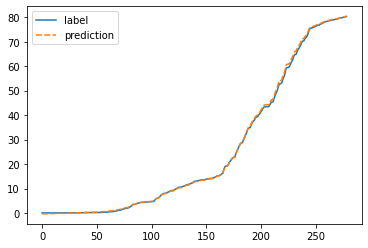

In [ ]:
label_result = invTransform(scaler, y.values, 'people_fully_vaccinated_per_hundred')
prediction_result = invTransform(scaler, prediction, 'people_fully_vaccinated_per_hundred')

result = pd.DataFrame(data={
    'label': label_result,
    'prediction': prediction_result
})
sns.lineplot(data=result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


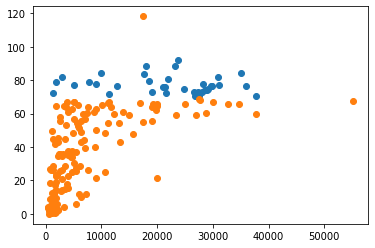

             vaccine_max       gdp    target
vaccine_max     1.000000  0.670072 -0.605892
gdp             0.670072  1.000000 -0.532061
target         -0.605892 -0.532061  1.000000


In [13]:
#GDP와 백신 접종률 비교, correlation 값 출력
import matplotlib.pyplot as plt
country_gdp = country_info.get("GDP ($ per capita)")
country_idx = country_info.get("Country")
for i in range(len(country_idx)):
  country_idx[i]= country_idx[i].strip()

country_gdp.index = country_idx

vac_gdp_data =[]
for k in vaccine_country_max.keys():
  if k in country_gdp.keys():
    if k in target_countries:
      vac_gdp_data.append([k,vaccine_country_max[k],country_gdp[k],0])
    else : 
      vac_gdp_data.append([k,vaccine_country_max[k],country_gdp[k],1])

df = pd.DataFrame(vac_gdp_data,columns=["country","vaccine_max","gdp","target"])
groups = df.groupby("target")
fig, ax = plt.subplots()
for name,group in groups:
  ax.plot(group.gdp, 
            group.vaccine_max, 
            marker='o', 
            linestyle='',
            label=name)
plt.show()

print(df.corr())

0    38.0
1    28.0
2    38.0
3    30.0
4    23.0
Name: Med. Age, dtype: float64


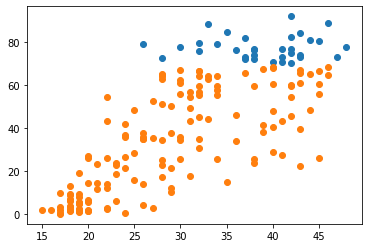

             vaccine_max   med_age    target
vaccine_max     1.000000  0.761331 -0.641943
med_age         0.761331  1.000000 -0.437560
target         -0.641943 -0.437560  1.000000


In [24]:
#GDP와 평균 나이 비교, correlation 값 출력
population_info = population_info[:201]
med_age = population_info.get('Med. Age').astype(float)
print(med_age.head())

med_age_country = population_info.get('Country (or dependency)')
med_age.index = med_age_country
vac_age_data = []
for k in vaccine_country_max.keys():
  if k in med_age.keys():
    if k in target_countries:
      vac_age_data.append([k,vaccine_country_max[k],med_age[k],0])
    else : 
      vac_age_data.append([k,vaccine_country_max[k],med_age[k],1])
    
df = pd.DataFrame(vac_age_data,columns=["country","vaccine_max","med_age","target"])
groups = df.groupby("target")
fig, ax = plt.subplots()
for name,group in groups:
  ax.plot(group.med_age, 
            group.vaccine_max, 
            marker='o', 
            linestyle='',
            label=name)
plt.show()

print(df.corr())